# Autoencoders
Based on Chap. 15 of `Hands-on Machine Learning with Scikit-Learn and TensorFlow` by A. Géron.

Autoencoders are networks used for learning efficient representations of data, called _codings_. Autoencoders are used, e.g., for dimensionality reduction, feature extraction, and unsupervised pretraining. Generative autoencoders are able to create new data that look similar to the training data. Autoencoders are trained by expecting them to copy their inputs to outputs. By constraining the network to have, e.g., smaller size of codings than the input, the network cannot trivially copy the inputs to outputs.

Let us first create a simple linear autoencoder with a single layer, which can be shown to be equivalent to PCA:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

/Users/ksaaskil/.pyenv/versions/3.5.0/envs/python3.5.0/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.preprocessing import StandardScaler

reset_graph()

n_inputs = 4
n_hidden = 2
n_outputs = n_inputs
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
# y = X

codings = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(codings, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

from sklearn.datasets import load_iris

# iris dataset
data = load_iris()
X_train = data['data']
X_train = StandardScaler().fit_transform(X=X_train)

n_epochs = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs + 1):
        mse, _ = sess.run([reconstruction_loss, training_op], feed_dict={X: X_train})
        if epoch % 10 == 0:
            print('Epoch: {}\tMSE: {:.2f}'.format(epoch,mse))
    projection = codings.eval(feed_dict={X: X_train})

Epoch: 10	MSE: 1.12
Epoch: 20	MSE: 0.85
Epoch: 30	MSE: 0.68
Epoch: 40	MSE: 0.55
Epoch: 50	MSE: 0.43
Epoch: 60	MSE: 0.34
Epoch: 70	MSE: 0.25
Epoch: 80	MSE: 0.17
Epoch: 90	MSE: 0.11
Epoch: 100	MSE: 0.08
Epoch: 110	MSE: 0.07
Epoch: 120	MSE: 0.06
Epoch: 130	MSE: 0.06
Epoch: 140	MSE: 0.05
Epoch: 150	MSE: 0.05
Epoch: 160	MSE: 0.05
Epoch: 170	MSE: 0.05
Epoch: 180	MSE: 0.05
Epoch: 190	MSE: 0.05
Epoch: 200	MSE: 0.05
Epoch: 210	MSE: 0.05
Epoch: 220	MSE: 0.05
Epoch: 230	MSE: 0.05
Epoch: 240	MSE: 0.05
Epoch: 250	MSE: 0.05
Epoch: 260	MSE: 0.05
Epoch: 270	MSE: 0.05
Epoch: 280	MSE: 0.05
Epoch: 290	MSE: 0.05
Epoch: 300	MSE: 0.05
Epoch: 310	MSE: 0.04
Epoch: 320	MSE: 0.04
Epoch: 330	MSE: 0.04
Epoch: 340	MSE: 0.04
Epoch: 350	MSE: 0.04
Epoch: 360	MSE: 0.04
Epoch: 370	MSE: 0.04
Epoch: 380	MSE: 0.04
Epoch: 390	MSE: 0.04
Epoch: 400	MSE: 0.04
Epoch: 410	MSE: 0.04
Epoch: 420	MSE: 0.04
Epoch: 430	MSE: 0.04
Epoch: 440	MSE: 0.04
Epoch: 450	MSE: 0.04
Epoch: 460	MSE: 0.04
Epoch: 470	MSE: 0.04
Epoch: 480	MSE: 0.04
E

PCA explained variance ratio: 0.9580097536148198


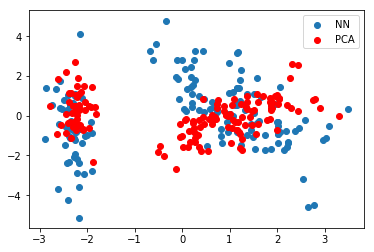

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_projection = pca.fit_transform(X=X_train)

print('PCA explained variance ratio:', np.sum(pca.explained_variance_ratio_))

import matplotlib.pyplot as plt

plt.scatter(projection[:, 1], projection[:, 0], label='NN')
plt.scatter(pca_projection[:, 0], pca_projection[:, 1], c='r', label='PCA')
plt.legend()
plt.show()

### Stacked autoencoders
Autoencoder with multiple hidden layers is called a _stacked autoencoder_ (or deep autoencoder). Adding layers helps the network to learn more complex codings, but one must be careful not to make the encoder too powerful. The architecture of the stacked autoencoder is typically symmetrical with respect to the center (coding) layer. It is common to tie the weights of the decoder layers to be equal to the weights of the encoder layers. This reduces the risk of overfitting and makes training faster.

There's no known easy way to tie the weights using `tf.layers.dense`, but it can be done by defining layers from scratch as follows.

In [4]:
from functools import partial
from tensorflow.examples.tutorials.mnist import input_data

reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu

kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
kernel_initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

weights1_init = kernel_initializer((n_inputs, n_hidden1))
weights2_init = kernel_initializer((n_hidden1, n_hidden2))

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.transpose(weights2, name='weights3')
weights4 = tf.transpose(weights1, name='weights4')

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
codings = hidden2
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = activation(tf.matmul(hidden3, weights4) + biases4)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = kernel_regularizer(weights1) + kernel_regularizer(weights2)

loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

mnist = input_data.read_data_sets("/tmp/mnist/data")

X_train = mnist.train.images

X_validation = mnist.validation.images

n_epochs = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs + 1):
        mse, _ = sess.run([loss, training_op], feed_dict={X: X_train})
        if epoch % 10 == 0:
            print('Epoch: {}\tMSE: {:.2f}'.format(epoch,mse))
    outputs_val = outputs.eval(feed_dict={X: X_validation})


Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz
Epoch: 10	MSE: 0.42
Epoch: 20	MSE: 0.18
Epoch: 30	MSE: 0.14
Epoch: 40	MSE: 0.11
Epoch: 50	MSE: 0.10
Epoch: 60	MSE: 0.09
Epoch: 70	MSE: 0.08
Epoch: 80	MSE: 0.08
Epoch: 90	MSE: 0.07
Epoch: 100	MSE: 0.07


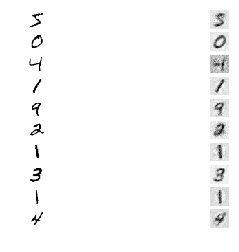

In [5]:
def plot_image(img, shape=(28, 28)):
    img = img.reshape(shape)
    plt.imshow(img, cmap='Greys', interpolation='nearest')
    plt.axis('off')
    
n_test_digits = 10

for i in range(n_test_digits):
    plt.subplot(n_test_digits, 2, i * 2 + 1)
    plot_image(X_validation[i])
    plt.subplot(n_test_digits, 2, i * 2 + 2)
    plot_image(outputs_val[i])

plt.show()

Instead of training the stacked autoencoder in one shot, it's often better to train shallow autoencoders one-by-one and then stack them.

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')

kernel_initializer = tf.contrib.layers.variance_scaling_initializer()

weights1_init = kernel_initializer((n_inputs, n_hidden1))
weights2_init = kernel_initializer((n_hidden1, n_hidden2))

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.transpose(weights2, name='weights3')
weights4 = tf.transpose(weights1, name='weights4')

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2, name='codings')

hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = activation(tf.matmul(hidden3, weights4) + biases4)

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='optimizer')

l2_reg = 1e-4
kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    
with tf.name_scope('phase1'):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = kernel_regularizer(weights1)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)
    
with tf.name_scope('phase2'):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = kernel_regularizer(weights2)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

mnist = input_data.read_data_sets("/tmp/mnist/data")

X_train = mnist.train.images

X_validation = mnist.validation.images

n_epochs = 50 # Per phase

with tf.Session() as sess:
    init.run()
    
    # Phase 1
    for epoch in range(1, n_epochs + 1):
        mse, _ = sess.run([phase1_loss, phase1_training_op], feed_dict={X: X_train})
        if epoch % 10 == 0:
            print('Phase 1 epoch: {}\tMSE: {:.2f}'.format(epoch,mse))
    h1_cache = hidden1.eval(feed_dict={X: X_train}) # Evaluate first layer outputs and feed in next phase
    phase1_outputs_val = phase1_outputs.eval(feed_dict={X: X_validation})
    
    # Phase 2
    for epoch in range(1, n_epochs + 1):
        mse, _ = sess.run([phase2_loss, phase2_training_op], feed_dict={hidden1: h1_cache})
        if epoch % 10 == 0:
            print('Phase 2 epoch: {}\tMSE: {:.2f}'.format(epoch,mse))
    phase2_outputs_val = outputs.eval(feed_dict={X: X_validation})
    
    saver.save(sess, './tf-logs/chap-15-stacked-autoencoder')

Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz
Phase 1 epoch: 10	MSE: 0.11
Phase 1 epoch: 20	MSE: 0.09
Phase 1 epoch: 30	MSE: 0.06
Phase 1 epoch: 40	MSE: 0.05
Phase 1 epoch: 50	MSE: 0.04
Phase 2 epoch: 10	MSE: 0.06
Phase 2 epoch: 20	MSE: 0.04
Phase 2 epoch: 30	MSE: 0.03
Phase 2 epoch: 40	MSE: 0.02
Phase 2 epoch: 50	MSE: 0.02


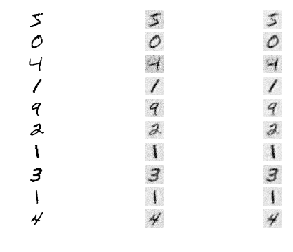

In [10]:
def plot_image(img, shape=(28, 28)):
    img = img.reshape(shape)
    plt.imshow(img, cmap='Greys', interpolation='nearest')
    plt.axis('off')
    
n_test_digits = 10

for i in range(n_test_digits):
    plt.subplot(n_test_digits, 3, i * 3 + 1)
    plot_image(X_validation[i])
    plt.subplot(n_test_digits, 3, i * 3 + 2)
    plot_image(phase1_outputs_val[i])
    plt.subplot(n_test_digits, 3, i * 3 + 3)
    plot_image(phase2_outputs_val[i])

plt.show()

### Unsupervised pretraining
It is typical in supervised machine learning that there are lots more training instances without labels available than instances without labels. For example, there are many more images available in the net than images with labels. In such cases, it makes sense to pretrain the network in unsupervised fashion: training an autoencoder to extract the relevant features, and then use the labeled data to train the classifier with the labeled data. 

In [11]:
# Dense classifier on top of the coding layer
reset_graph()
saver = tf.train.import_meta_graph('./tf-logs/chap-15-stacked-autoencoder.meta')

n_hidden1 = 100
n_hidden2 = 50
n_classes = 10
learning_rate = 0.01

graph = tf.get_default_graph()

X = graph.get_tensor_by_name('X:0')
y = tf.placeholder(tf.int32, shape=(None))
codings = graph.get_tensor_by_name('codings:0')

he_init = tf.contrib.layers.variance_scaling_initializer(mode='FAN_AVG')
dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_init)

with tf.name_scope('classifier'):
    fc_layer1 = dense_layer(codings, n_hidden1, name='fc_layer1')
    fc_layer2 = dense_layer(fc_layer1, n_hidden2, name='fc_layer2')
    logits = dense_layer(fc_layer2, n_classes, activation=None, name='logits')

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope("train_clf"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="logits|fc_layer[12]") # Only train the classifier layer
    assert len(train_vars) == 6 # Three layers with weights and biases each
    training_op = optimizer.minimize(loss, var_list=train_vars)

init = tf.global_variables_initializer()

mnist = input_data.read_data_sets("/tmp/mnist/data")

X_train = mnist.train.images
y_train = mnist.train.labels

X_validation = mnist.validation.images
y_validation = mnist.validation.labels

n_epochs = 500

with tf.Session() as sess:
    init.run() # Initialize variables (required for those not in the restored graph)
    saver.restore(sess, './tf-logs/chap-15-stacked-autoencoder') # Restore autoencoder
    codings_train = codings.eval(feed_dict={X: X_train})

    for epoch in range(1, n_epochs + 1):
        train_loss, train_acc, _ = sess.run([loss, accuracy, training_op], feed_dict={codings: codings_train, y: y_train})
        if epoch % 50 == 0:
            val_loss, val_acc = sess.run([loss, accuracy], feed_dict={X: X_validation, y:y_validation})
            print('Classifier epoch: {}\tTrain loss: {:.2f}\tTrain acc: {:.3f} %\tVal loss: {:.2f}\tVal acc: {:.2f} %'
                  .format(epoch, train_loss, train_acc*100, val_loss, val_acc * 100))


Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./tf-logs/chap-15-stacked-autoencoder
Classifier epoch: 50	Train loss: 0.22	Train acc: 93.429 %	Val loss: 0.20	Val acc: 93.92 %
Classifier epoch: 100	Train loss: 0.13	Train acc: 95.887 %	Val loss: 0.13	Val acc: 96.16 %
Classifier epoch: 150	Train loss: 0.10	Train acc: 97.060 %	Val loss: 0.11	Val acc: 96.94 %
Classifier epoch: 200	Train loss: 0.07	Train acc: 97.756 %	Val loss: 0.09	Val acc: 97.36 %
Classifier epoch: 250	Train loss: 0.06	Train acc: 98.267 %	Val loss: 0.08	Val acc: 97.60 %
Classifier epoch: 300	Train loss: 0.05	Train acc: 98.687 %	Val loss: 0.07	Val acc: 97.74 %
Classifier epoch: 350	Train loss: 0.04	Train acc: 99.067 %	Val loss: 0.07	Val acc: 97.86 %
Classifier epoch: 400	Train loss: 0.03	Train acc: 99.320 %	Val loss: 0

### Denoising and sparse autoencoders
Skipped.

### Variational autoencoders

In a variational autoencoder, the coding layer produces probability distribution parameters like the mean $\mathbf{\mu}$ and standard deviation $\mathbf{\sigma}$ of a multivariable Gaussian distribution. The actual encoding for a given training instance is sampled from this distribution. After training, one can easily create new training instances by sampling encoding from the probability distribution and feeding it to the encoder. 

The cost function is composed of two parts, the first of which is the simple reconstruction loss used above. The second part is the _latent loss_ that pushes the autoencoder to have encodings that look like they were sampled from the Gaussian distribution. For this, the KL divergence between the encoding distribution and the target (Gaussian) distribution is used as the loss.

Below, $\gamma=\log(\sigma^2)$.

In [14]:
from functools import partial
from tensorflow.examples.tutorials.mnist import input_data

reset_graph()

n_inputs = 28*28
n_hidden1 = 500
n_hidden2 = 400
n_hidden3 = 20 # Codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

kernel_initializer = tf.contrib.layers.variance_scaling_initializer()

dense_layer = partial(
    tf.layers.dense, 
    activation=tf.nn.elu, 
    kernel_initializer=kernel_initializer)

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

hidden1 = dense_layer(X, n_hidden1, name='hidden1')
hidden2 = dense_layer(hidden1, n_hidden2, name='hidden2')
hidden3_mean = dense_layer(hidden2, n_hidden3, name='hidden3_mean')
hidden3_gamma = dense_layer(hidden2, n_hidden3, name='hidden3_gamma')
noise = tf.random_normal(tf.shape(hidden3_mean), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_gamma * noise
hidden4 = dense_layer(hidden3, n_hidden4, name='hidden4')
hidden5 = dense_layer(hidden4, n_hidden5, name='hidden5')
logits = dense_layer(hidden5, n_outputs, activation=None, name=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

mnist = input_data.read_data_sets("/tmp/mnist/data")
X_train = mnist.train.images
X_validation = mnist.validation.images

n_epochs = 50
batch_size = 200
with tf.Session() as sess:
    init.run()
    
    for epoch in range(1, n_epochs + 1):
        n_batches = mnist.train.num_examples // batch_size
        for i in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            train_loss, _ = sess.run([loss, training_op], feed_dict={X: X_batch})
        if epoch % 5 == 0:
            val_loss = sess.run(loss, feed_dict={X: X_validation})
            print('Epoch: {}\tTrain loss: {:.2f}\tVal loss: {:.2f}'.format(epoch, train_loss, val_loss))

    saver.save(sess, './tf-logs/chap15-variational-autoencoder')

Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz
Epoch: 5	Train loss: 15118.90	Val loss: 392406.56
Epoch: 10	Train loss: 14345.35	Val loss: 366407.59
Epoch: 15	Train loss: 14431.36	Val loss: 352129.44
Epoch: 20	Train loss: 13353.47	Val loss: 345583.09
Epoch: 25	Train loss: 13250.07	Val loss: 342472.34
Epoch: 30	Train loss: 12897.33	Val loss: 338544.59
Epoch: 35	Train loss: 12565.84	Val loss: 335866.47
Epoch: 40	Train loss: 13631.25	Val loss: 332758.88
Epoch: 45	Train loss: 12903.88	Val loss: 334639.25
Epoch: 50	Train loss: 12983.73	Val loss: 329346.31


Now create some images by sampling codings from a zero-mean unit-std normal distribution:

INFO:tensorflow:Restoring parameters from ./tf-logs/chap15-variational-autoencoder


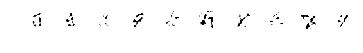

In [15]:
import numpy as np

n_test_digits = 10

codings_rnd = np.random.normal(size=(n_test_digits, n_hidden3))

def plot_image(img, shape=(28, 28)):
    img = img.reshape(shape)
    plt.imshow(img, cmap='Greys', interpolation='nearest')
    plt.axis('off')

with tf.Session() as sess:
    saver.restore(sess, './tf-logs/chap15-variational-autoencoder')
    output_imgs = outputs.eval(feed_dict={hidden3: codings_rnd})
    
for i in range(n_test_digits):
    plt.subplot(n_test_digits, 10, i + 1)
    plot_image(output_imgs[i])
    
plt.show()